## Pose_Estimation

### Install requierd libraries

In [ ]:
'''Install requiered dependencies/libraries
-pip install numpy
-pip install opencv-python
-pip install scikit-learn
-pip install tensorflow
-pip install keras
-pip install hmmlearn
-pip install matplotlib
-pip install matplotlib
'''

### Import installed and required python libraries

In [1]:
#Import requiered  installed libraries
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
#from hmmlearn import hmm

### 1) Load & Process the dataset

In [2]:
# Constants
exercise = "squat"
keypoint_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

In [3]:
# Process the JSON files and extract pose data
def process_json_files(data_dir):
    data = []
    labels = []

    # Iterate over the folders in the data directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip non-directory files (e.g., .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        # Determine the label based on whether it's the trainer or trainee folder
        if folder_name == "s08":
            label = "correct"
        else:
            label = "incorrect"

        # Path to the joints3d_25 folder
        joints3d_path = os.path.join(folder_path, "joints3d_25")

        # Iterate over the files in the joints3d_25 folder
        for filename in os.listdir(joints3d_path):
            if filename.endswith(".json") and filename != ".DS_Store":
                file_path = os.path.join(joints3d_path, filename)

                # Open and parse the JSON file
                with open(file_path, "r") as f:
                    json_data = json.load(f)

                # Extract skeleton coordinates for each frame
                for frame_data in json_data["joints3d_25"]:
                    pose_data = []

                    # Extract coordinates for each body part
                    for part_coords in frame_data:
                        pose_data.extend(part_coords)

                    # Append the pose data and label to the lists
                    data.append(pose_data)
                    labels.append(label)

    return data, labels

# Specify the data directory
data_dir = "D:/AI/pos_estimation/train/train"

# Process the JSON files and extract pose data
data, labels = process_json_files(data_dir)

# Print the shape of the data and labels
print("Data shape:", len(data))
print("Labels shape:", len(labels))


Data shape: 20901
Labels shape: 20901


In [4]:
# Process the JSON files and extract pose data
data, labels = process_json_files(data_dir)

In [5]:
# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

In [7]:
print("Length of X_train:", len(X_train))
print("Length of X_test:", len(X_test))

Length of X_train: 16720
Length of X_test: 4181


In [8]:
# Convert data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

In [9]:
# Reshape the data
X_train = tf.reshape(X_train, shape=(-1, 25, 3))
X_test = tf.reshape(X_test, shape=(-1, 25, 3))

In [10]:
# Normalize the data
X_train /= 255.0
X_test /= 255.0

In [49]:
# Print the shape of train and test data
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (16720, 25, 3)
X_test shape: (4181, 25, 3)


### 2) Feature Extraction with CNN

1) Model

In [11]:
# Build the CNN model
model = tf.keras.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(25, 3)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # For labels/targets we have 2 classes: correct and incorrect
])

In [13]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 32)            320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                1

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model and store the training history
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
523/523 [==============================] - 6s 8ms/step - loss: 0.1797 - accuracy: 0.9417 - val_loss: 0.2044 - val_accuracy: 0.9266
Epoch 2/10
523/523 [==============================] - 4s 7ms/step - loss: 0.1613 - accuracy: 0.9453 - val_loss: 0.1574 - val_accuracy: 0.9366
Epoch 3/10
523/523 [==============================] - 4s 7ms/step - loss: 0.1394 - accuracy: 0.9511 - val_loss: 0.1286 - val_accuracy: 0.9584
Epoch 4/10
523/523 [==============================] - 3s 6ms/step - loss: 0.1212 - accuracy: 0.9584 - val_loss: 0.1052 - val_accuracy: 0.9687
Epoch 5/10
523/523 [==============================] - 3s 6ms/step - loss: 0.1013 - accuracy: 0.9660 - val_loss: 0.0930 - val_accuracy: 0.9687
Epoch 6/10
523/523 [==============================] - 4s 7ms/step - loss: 0.0882 - accuracy: 0.9733 - val_loss: 0.0860 - val_accuracy: 0.9720
Epoch 7/10
523/523 [==============================] - 6s 11ms/step - loss: 0.0673 - accuracy: 0.9796 - val_loss: 0.0611 - val_accuracy: 0.9892
Epoch

#### Validation parameters

In [49]:
# Calculate the average accuracy and error
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# Print the average accuracy and error
print("Average Accuracy:")
print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Validation Accuracy: {val_acc:.4f}")

print("Average Loss:")
print(f"  Training Loss: {train_loss:.4f}")
print(f"  Validation Loss: {val_loss:.4f}")

Average Accuracy:
  Training Accuracy: 0.9921
  Validation Accuracy: 0.9782
Average Loss:
  Training Loss: 0.0324
  Validation Loss: 0.0551


#### Plot the training results

In [50]:
# Get the training and validation metrics from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

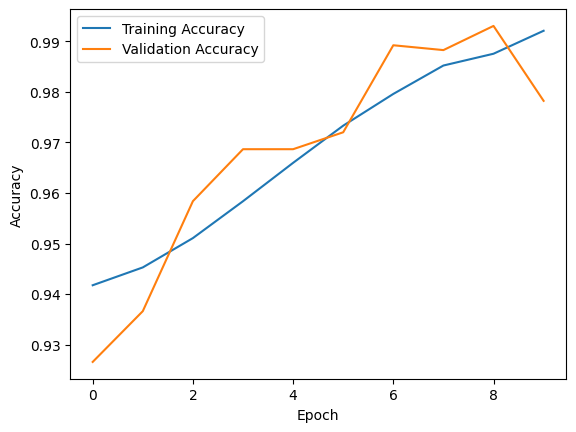

In [51]:
# Plot the training and validation accuracy
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

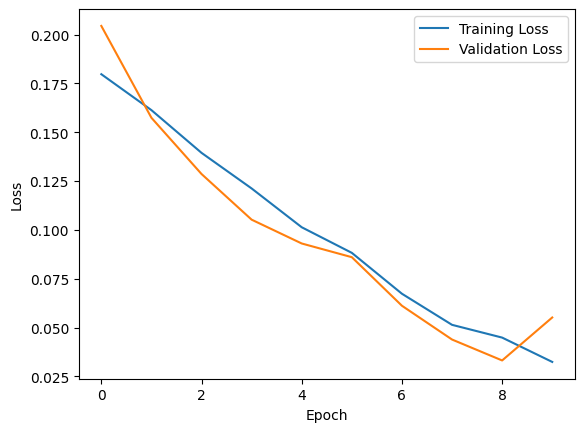

In [52]:
# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Save the best model

In [57]:
# Specify the path to save the model
path_to_save_model = "D:/AI/pos_estimation/best_models/one"

# Save the model
model.save(path_to_save_model)

INFO:tensorflow:Assets written to: D:/AI/pos_estimation/best_models/one\assets


INFO:tensorflow:Assets written to: D:/AI/pos_estimation/best_models/one\assets


#### Test the above model

#### Notice that:
- 0 : INCORRECT
- 1 : CORRECT

In [62]:
import cv2
import tensorflow as tf
import numpy as np

# Load the pre-trained PoseNet model
model = tf.keras.applications.MobileNetV2(weights='imagenet')

# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)
    
    # List to store the extracted coordinates
    coordinates = []
    
    # Loop through the video frames
    while True:
        ret, frame = video.read()
        
        if not ret:
            break
        
        # Preprocess the frame for input to PoseNet model
        input_frame = cv2.resize(frame, (224, 224))
        input_frame = tf.keras.applications.mobilenet_v2.preprocess_input(input_frame)
        input_frame = np.expand_dims(input_frame, axis=0)
        
        # Predict the poses using PoseNet model
        predictions = model.predict(input_frame)
        
        # Extract the coordinates from the predictions
        pose_coordinates = extract_coordinates_from_predictions(predictions)
        
        # Append the pose coordinates to the list
        coordinates.append(pose_coordinates)
    
    # Convert the list to a numpy array
    coordinates = np.array(coordinates)
    
    return coordinates

# Function to extract coordinates from PoseNet predictions
def extract_coordinates_from_predictions(predictions):
    # Implement the logic to extract the coordinates from PoseNet predictions
    # Return the extracted coordinates

    # Placeholder implementation
    coordinates = np.zeros((25, 3))
    
    return coordinates

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    #r's13\videos\squat.mp4',
    #r's02\videos\squat.mp4',
    r's12\videos\squat.mp4'
]

# List to store the extracted coordinates
test_data = []

# Extract coordinates from the test videos
for video in test_videos:
    video_path = os.path.join(test_folder, video)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates are:", coordinates)
    num_frames = len(coordinates)
    print("Number of frames extracted:", num_frames)
    test_data.extend(coordinates)

# Convert the list to a numpy array
test_data = np.array(test_data)

# Perform any required preprocessing on the test data
preprocessed_test_data = np.expand_dims(preprocessed_test_data, axis=0)   # Placeholder preprocessing step

# Use the trained CNN model to predict the correctness of the poses
predictions = model.predict(preprocessed_test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels or perform further analysis
print("Predicted Labels:", predicted_labels)


1/1 [==============================] - 0s 112ms/step
Coordinates are:
Frame 1 :
Point 1 : (0.000, 0.000, 0.000)
Point 2 : (0.000, 0.000, 0.000)
Point 3 : (0.000, 0.000, 0.000)
Point 4 : (0.000, 0.000, 0.000)
Point 5 : (0.000, 0.000, 0.000)
Point 6 : (0.000, 0.000, 0.000)
Point 7 : (0.000, 0.000, 0.000)
Point 8 : (0.000, 0.000, 0.000)
Point 9 : (0.000, 0.000, 0.000)
Point 10 : (0.000, 0.000, 0.000)
Point 11 : (0.000, 0.000, 0.000)
Point 12 : (0.000, 0.000, 0.000)
Point 13 : (0.000, 0.000, 0.000)
Point 14 : (0.000, 0.000, 0.000)
Point 15 : (0.000, 0.000, 0.000)
Point 16 : (0.000, 0.000, 0.000)
Point 17 : (0.000, 0.000, 0.000)
Point 18 : (0.000, 0.000, 0.000)
Point 19 : (0.000, 0.000, 0.000)
Point 20 : (0.000, 0.000, 0.000)
Point 21 : (0.000, 0.000, 0.000)
Point 22 : (0.000, 0.000, 0.000)
Point 23 : (0.000, 0.000, 0.000)
Point 24 : (0.000, 0.000, 0.000)
Point 25 : (0.000, 0.000, 0.000)
Frame 2 :
Point 1 : (0.000, 0.000, 0.000)
Point 2 : (0.000, 0.000, 0.000)
Point 3 : (0.000, 0.000, 0.000

InvalidArgumentError: Graph execution error:

Detected at node 'mobilenetv2_1.00_224/Conv1_relu/Relu6' defined at (most recent call last):
    File "C:\Users\HP\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\HP\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\HP\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\HP\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\HP\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\HP\AppData\Local\Temp\ipykernel_13848\666800693.py", line 86, in <module>
      predictions = model.predict(preprocessed_test_data)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\layers\activation\relu.py", line 105, in call
      return backend.relu(
    File "d:\AI\pos_estimation\pose_estimation\lib\site-packages\keras\backend.py", line 5393, in relu
      x = tf.nn.relu6(x)
Node: 'mobilenetv2_1.00_224/Conv1_relu/Relu6'
convolution input must be 4-dimensional: [1,1,1307,25,3]
	 [[{{node mobilenetv2_1.00_224/Conv1_relu/Relu6}}]] [Op:__inference_predict_function_352687]

In [59]:
# Function to extract frames and get coordinates from a video
def extract_frames_and_get_coordinates(video_path):
    # Perform frame extraction and coordinate extraction
    # Return the extracted coordinates

    # Placeholder implementation
    coordinates = np.zeros((10, 25, 3))  # Modify this line with the actual extraction logic

    return coordinates

# Specify the path to the test folder
test_folder = r'D:\AI\pos_estimation\test\test'

# Get the list of test videos
test_videos = [
    #r's13\videos\squat.mp4',
    #r's02\videos\squat.mp4',
    r's12\videos\squat.mp4'
]

# Load the trained CNN model
model = load_model(r'D:\AI\pos_estimation\best_models\one')

# List to store the extracted coordinates
test_data = []

# Extract coordinates from the test videos
for video in test_videos:
    video_path = os.path.join(test_folder, video)
    coordinates = extract_frames_and_get_coordinates(video_path)
    print("Coordinates are:", coordinates)
    num_frames = len(coordinates)
    print("Number of frames extracted:", num_frames)
    test_data.extend(coordinates)

# Convert the list to a numpy array
test_data = np.array(test_data)

# Perform any required preprocessing on the test data
preprocessed_test_data = test_data  # Placeholder preprocessing step

# Use the trained CNN model to predict the correctness of the poses
predictions = model.predict(preprocessed_test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels or perform further analysis
print("Predicted Labels:", predicted_labels)


Coordinates are: [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [

In [25]:
import cv2
import numpy as np
import tensorflow as tf

# Load the test video and extract frames
video_path = "D:/AI/pos_estimation/test/test/s02/videos/squat.mp4"  # Replace with the actual path to the test video
#path_to_saved_model = ""

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video file:", video_path)
    exit()

frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()

print("Number of frames:", len(frames))

# Process the frames and extract pose data
pose_data = []
# ... code for pose estimation on each frame ...
# Assuming you have a list of pose keypoints for each frame and stored in 'pose_data'

# Prepare the test data
test_data = np.array(pose_data)
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)
test_data = tf.reshape(test_data, shape=(-1, 25, 3))
test_data /= 255.0

# Load the trained model
model = tf.keras.models.load_model('D:/AI/pos_estimation/best_models/one/')  # Replace 'path_to_saved_model' with the actual path

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Test the model
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels or perform further analysis
print(predicted_labels)


Number of frames: 1736


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [26]:
import cv2
import tensorflow as tf

# Load the pre-trained pose estimation model
pose_model = tf.keras.models.load_model('D:/AI/pos_estimation/best_models/one/')  # Replace 'path_to_pose_model' with the actual path

# Function for frame preprocessing
def preprocess_frame(frame):
    # Resize the frame if required
    # ... code for resizing the frame ...

    # Normalize the frame if required
    # ... code for normalizing the frame ...

    # Return the preprocessed frame
    return preprocessed_frame

# Open the video file
video_path = 'D:/AI/pos_estimation/test/test/s02/videos/squat.mp4'  # Replace 'path_to_video_file' with the actual path to your video file
video_capture = cv2.VideoCapture(video_path)

# Initialize a list to store the frames with joint coordinates
frames_with_joints = []

# Loop through each frame in the video
while video_capture.isOpened():
    ret, frame = video_capture.read()

    if not ret:
        break

    # Preprocess the frame
    preprocessed_frame = preprocess_frame(frame)

    # Run the pre-trained pose estimation model on the frame
    pose_coordinates = pose_model.predict(preprocessed_frame)

    # Store the frame along with the coordinates of the joints
    frames_with_joints.append((frame, pose_coordinates))

# Release the video capture object
video_capture.release()

# Test the CNN model on the frames with joint coordinates
for frame, joint_coordinates in frames_with_joints:
    # ... code for testing the CNN model on each frame with joint coordinates ...
    pass

NameError: name 'preprocessed_frame' is not defined

### Other model

In [31]:
# Constants
exercise = "squat"
keypoint_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# Process the JSON files and extract pose data
def process_json_files(data_dir):
    data = []
    labels = []

    # Iterate over the folders in the data directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip non-directory files (e.g., .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        # Determine the label based on whether it's the trainer or trainee folder
        if folder_name == "s08":
            label = "correct"
        else:
            label = "incorrect"

        # Path to the joints3d_25 folder
        joints3d_path = os.path.join(folder_path, "joints3d_25")

        # Iterate over the files in the joints3d_25 folder
        for filename in os.listdir(joints3d_path):
            if filename.endswith(".json") and filename != ".DS_Store":
                file_path = os.path.join(joints3d_path, filename)

                # Open and parse the JSON file
                with open(file_path, "r") as f:
                    json_data = json.load(f)

                # Extract skeleton coordinates for each frame
                for frame_data in json_data["joints3d_25"]:
                    pose_data = []

                    # Extract coordinates for each body part
                    for index in keypoint_indices:
                        part_coords = frame_data[index]
                        pose_data.extend(part_coords)

                    # Append the pose data and label to the lists
                    data.append(pose_data)
                    labels.append(label)

    return data, labels

# Specify the data directory
data_dir = "D:/AI/pos_estimation/train/train"

# Process the JSON files and extract pose data
data, labels = process_json_files(data_dir)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Convert data to tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

# Reshape the data
X_train = tf.reshape(X_train, shape=(-1, 25, 3))
X_test = tf.reshape(X_test, shape=(-1, 25, 3))

# Normalize the data
X_train /= 255.0
X_test /= 255.0

# CNN Model
cnn_model = tf.keras.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(25, 3)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: correct, incorrect, almost correct
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
523/523 [==============================] - 6s 7ms/step - loss: 0.3732 - accuracy: 0.8902 - val_loss: 0.3576 - val_accuracy: 0.8852
Epoch 2/10
523/523 [==============================] - 3s 6ms/step - loss: 0.3432 - accuracy: 0.8916 - val_loss: 0.3549 - val_accuracy: 0.8852
Epoch 3/10
523/523 [==============================] - 3s 5ms/step - loss: 0.3372 - accuracy: 0.8916 - val_loss: 0.3566 - val_accuracy: 0.8852
Epoch 4/10
523/523 [==============================] - 3s 5ms/step - loss: 0.3026 - accuracy: 0.8942 - val_loss: 0.2673 - val_accuracy: 0.8974
Epoch 5/10
523/523 [==============================] - 3s 7ms/step - loss: 0.2489 - accuracy: 0.9233 - val_loss: 0.2436 - val_accuracy: 0.9273
Epoch 6/10
523/523 [==============================] - 3s 5ms/step - loss: 0.2315 - accuracy: 0.9294 - val_loss: 0.2299 - val_accuracy: 0.9323
Epoch 7/10
523/523 [==============================] - 3s 5ms/step - loss: 0.2204 - accuracy: 0.9328 - val_loss: 0.2219 - val_accuracy: 0.9357
Epoch 

                                        **********************************

### HMM Model

#### Try-1

In [ ]:
# Extract features from the trained CNN model
train_features = cnn_model.predict(X_train)
test_features = cnn_model.predict(X_test)

# Organize features into sequences for each repetition of the exercise
exercise_sequences_train = []
exercise_sequences_test = []

# Create sequence for training set
current_sequence = []
current_label = y_train[0]
for i in range(len(train_features)):
    if y_train[i] == current_label:
        current_sequence.append(train_features[i])
    else:
        exercise_sequences_train.append(current_sequence)
        current_sequence = [train_features[i]]
        current_label = y_train[i]
exercise_sequences_train.append(current_sequence)

# Create sequence for test set
current_sequence = []
current_label = y_test[0]
for i in range(len(test_features)):
    if y_test[i] == current_label:
        current_sequence.append(test_features[i])
    else:
        exercise_sequences_test.append(current_sequence)
        current_sequence = [test_features[i]]
        current_label = y_test[i]
exercise_sequences_test.append(current_sequence)

# Train an HMM model on the feature sequences
num_states = 3  # Specify the desired number of HMM states

hmm_model = hmm.GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=100)
for sequence in exercise_sequences_train:
    hmm_model.fit(sequence)

# Evaluate the trained HMM model on the test set and calculate performance metrics
predicted_labels = []
for sequence in exercise_sequences_test:
    sequence_likelihoods = []
    for state in range(num_states):
        log_likelihood = hmm_model.score(sequence)
        sequence_likelihoods.append(log_likelihood)
    predicted_label = np.argmax(sequence_likelihoods)
    predicted_labels.append(predicted_label)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)


#### Try-2

In [19]:
# Extract features from the trained CNN model
train_features = cnn_model.predict(X_train)
test_features = cnn_model.predict(X_test)

# Organize features into sequences for each repetition of the exercise
exercise_sequences_train = []
exercise_sequences_test = []

# Create sequence for training set
current_sequence = []
current_label = y_train[0]
for i in range(len(train_features)):
    if y_train[i] == current_label:
        current_sequence.append(train_features[i])
    else:
        exercise_sequences_train.append(current_sequence)
        current_sequence = [train_features[i]]
        current_label = y_train[i]
exercise_sequences_train.append(current_sequence)

# Create sequence for test set
current_sequence = []
current_label = y_test[0]
for i in range(len(test_features)):
    if y_test[i] == current_label:
        current_sequence.append(test_features[i])
    else:
        exercise_sequences_test.append(current_sequence)
        current_sequence = [test_features[i]]
        current_label = y_test[i]
exercise_sequences_test.append(current_sequence)

# Train an HMM model on the feature sequences
num_states = 3  # Specify the desired number of HMM states

hmm_model = hmm.GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=100)
for sequence in exercise_sequences_train:
    hmm_model.fit(sequence)

# Evaluate the trained HMM model on the test set and calculate performance metrics
predicted_labels = []
for sequence in exercise_sequences_test:
    sequence_likelihoods = []
    for state in range(num_states):
        log_likelihood = hmm_model.score(sequence)
        sequence_likelihoods.append(log_likelihood)
    predicted_label = np.argmax(sequence_likelihoods)
    predicted_labels.append(predicted_label)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)


131/131 [==============================] - 1s 5ms/step


Model is not converging.  Current: 55.6733104794739 is not greater than 62.73782106764467. Delta is -7.064510588170769
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Fitting a model with 26 free scalar parameters with only 3 data points will result in a degenerate solution.
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


ValueError: n_samples=1 should be >= n_clusters=3.

#### Try-3

In [ ]:
# Train an HMM model on the feature sequences
num_states = 3  # Specify the desired number of HMM states

hmm_models = []  # List to store HMM models for each repetition
for sequence in exercise_sequences_train:
    if len(sequence) >= num_states:
        hmm_model = hmm.GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=100)
        hmm_model.fit(sequence)
        hmm_models.append(hmm_model)

# Evaluate the trained HMM models on the test set and calculate performance metrics
predicted_labels = []
for sequence in exercise_sequences_test:
    if len(sequence) >= num_states:
        sequence_likelihoods = []
        for hmm_model in hmm_models:
            log_likelihood = hmm_model.score(sequence)
            sequence_likelihoods.append(log_likelihood)
        predicted_label = np.argmax(sequence_likelihoods)
        predicted_labels.append(predicted_label)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)


#### Try-4

In [ ]:
# Train an HMM model on the feature sequences
num_states = 3  # Specify the desired number of HMM states

hmm_models = []  # List to store HMM models for each repetition
for sequence in exercise_sequences_train:
    if len(sequence) >= num_states:
        hmm_model = hmm.GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=100, startprob_prior=np.full(num_states, 1/num_states))
        hmm_model.fit(sequence)
        hmm_models.append(hmm_model)

# Evaluate the trained HMM models on the test set and calculate performance metrics
predicted_labels = []
for sequence in exercise_sequences_test:
    if len(sequence) >= num_states:
        sequence_likelihoods = []
        for hmm_model in hmm_models:
            log_likelihood = hmm_model.score(sequence)
            sequence_likelihoods.append(log_likelihood)
        predicted_label = np.argmax(sequence_likelihoods)
        predicted_labels.append(predicted_label)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)

#### Try-5

In [ ]:
# Train an HMM model on the feature sequences
num_states = 3  # Specify the desired number of HMM states

hmm_models = []  # List to store HMM models for each repetition
for sequence in exercise_sequences_train:
    if len(sequence) >= num_states:
        hmm_model = hmm.GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=100)
        hmm_model.startprob_ = np.full(num_states, 1/num_states)
        hmm_model.fit(sequence)
        hmm_models.append(hmm_model)

# Evaluate the trained HMM models on the test set and calculate performance metrics
predicted_labels = []
for sequence in exercise_sequences_test:
    if len(sequence) >= num_states:
        sequence_likelihoods = []
        for hmm_model in hmm_models:
            log_likelihood = hmm_model.score(sequence)
            sequence_likelihoods.append(log_likelihood)
        predicted_label = np.argmax(sequence_likelihoods)
        predicted_labels.append(predicted_label)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)


#### Try-6

In [ ]:
# Train an HMM model on the feature sequences
num_states = 3  # Specify the desired number of HMM states

hmm_models = []  # List to store HMM models for each repetition
for sequence in exercise_sequences_train:
    if len(sequence) >= num_states:
        hmm_model = hmm.GaussianHMM(n_components=num_states, covariance_type="diag", n_iter=100)
        hmm_model.startprob_ = np.full(num_states, 1/num_states)
        hmm_model.fit(sequence)
        hmm_model.startprob_ = hmm_model.startprob_ / np.sum(hmm_model.startprob_)  # Normalize start probabilities
        hmm_models.append(hmm_model)

# Evaluate the trained HMM models on the test set and calculate performance metrics
predicted_labels = []
for sequence in exercise_sequences_test:
    if len(sequence) >= num_states:
        sequence_likelihoods = []
        for hmm_model in hmm_models:
            log_likelihood = hmm_model.score(sequence)
            sequence_likelihoods.append(log_likelihood)
        predicted_label = np.argmax(sequence_likelihoods)
        predicted_labels.append(predicted_label)

accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)


#### Try-7

In [ ]:
# Extract features from the trained CNN
train_features = model.predict(X_train)
test_features = model.predict(X_test)

# Organize features into sequences for each repetition of the exercise
# Assuming each repetition consists of 5 frames
n_frames_per_repetition = 5
train_sequences = np.split(train_features, len(X_train) // n_frames_per_repetition)
test_sequences = np.split(test_features, len(X_test) // n_frames_per_repetition)

# Train an HMM model
hmm_model = hmm.GaussianHMM(n_components=3, covariance_type="diag")
hmm_model.fit(train_sequences)

# Predict labels using the HMM model
train_predictions = hmm_model.predict(train_sequences)
test_predictions = hmm_model.predict(test_sequences)

# Evaluate the performance of the HMM model
train_accuracy = (train_predictions == y_train.reshape(-1, n_frames_per_repetition)).mean()
test_accuracy = (test_predictions == y_test.reshape(-1, n_frames_per_repetition)).mean()

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

### Train the CNN using the labeled pose data, with correct and incorrect poses as target labels

In [33]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(25, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [34]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [35]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

ValueError: Data cardinality is ambiguous:
  x sizes: 5
  y sizes: 16720
Make sure all arrays contain the same number of samples.

#### Fine-tune the CNN to optimize its performance on pose classification

In [36]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(25, 3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [37]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [38]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

In [39]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

ValueError: Data cardinality is ambiguous:
  x sizes: 5
  y sizes: 16720
Make sure all arrays contain the same number of samples.

2

In [143]:
# Process the JSON files and extract pose data
def process_json_files(data_dir, repetition_count):
    data = []
    labels = []

    # Iterate over the folders in the data directory
    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)

        # Skip non-directory files (e.g., .DS_Store)
        if not os.path.isdir(folder_path):
            continue

        # Determine the label based on whether it's the trainer or trainee folder
        if folder_name == "s08":
            label = "correct"
        else:
            label = "incorrect"

        # Path to the joints3d_25 folder
        joints3d_path = os.path.join(folder_path, "joints3d_25")

        # Iterate over the files in the joints3d_25 folder
        for filename in os.listdir(joints3d_path):
            if filename.endswith(".json") and filename != ".DS_Store":
                file_path = os.path.join(joints3d_path, filename)

                # Open and parse the JSON file
                with open(file_path, "r") as f:
                    json_data = json.load(f)

                # Extract skeleton coordinates for each frame
                frame_count = len(json_data["joints3d_25"])
                if frame_count >= repetition_count:
                    for i in range(repetition_count):
                        pose_data = []
                        start_frame = i * (frame_count // repetition_count)
                        end_frame = (i + 1) * (frame_count // repetition_count)

                        # Extract coordinates for each body part in the specified frame range
                        for frame_data in json_data["joints3d_25"][start_frame:end_frame]:
                            for part_coords in frame_data:
                                pose_data.extend(part_coords)

                        # Append the pose data and label to the lists
                        data.append(pose_data)
                        labels.append(label)

    return data, labels


# Specify the data directory and repetition count
data_dir = "D:/AI/pos_estimation/train/train"
repetition_count = 5

# Process the JSON files and extract pose data
data, labels = process_json_files(data_dir, repetition_count)

# Print the shape of the data and labels
print("Data shape:", len(data))
print("Labels shape:", len(labels))

Data shape: 80
Labels shape: 80


In [50]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the CNN model
def build_cnn_model(input_shape):
    model = tf.keras.Sequential()

    # Convolutional layers
    model.add(layers.Conv1D(32, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(64, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification

    return model

# Specify the input shape based on your data
input_shape = (25, 3)  # Assuming each sequence has 25 frames with 3 coordinates (x, y, z)

# Build the CNN model
model = build_cnn_model(input_shape)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 23, 32)            320       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 11, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 9, 64)             6208      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 2, 128)            24704     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1, 128)          

In [51]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_val, y_val)
print("Validation loss:", loss)
print("Validation accuracy:", accuracy)



NameError: name 'X_val' is not defined

### 3) Temporal Modeling with HMM

In [132]:
# Extract the features from the CNN for each frame of the pose data:
from tensorflow.keras.models import Model

# Define the feature extraction model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features from the CNN for each frame of pose data
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)


131/131 [==============================] - 0s 2ms/step


In [ ]:
# Assuming you have identified the start and end indices for each repetition
repetition_indices = [(start1, end1), (start2, end2), ...]

# Initialize empty lists to store the organized feature sequences
organized_train_sequences = []
organized_test_sequences = []

# Organize the features into sequences for each repetition in the training data
for start, end in repetition_indices:
    sequence = X_train_features[start:end]
    organized_train_sequences.append(sequence)

# Organize the features into sequences for each repetition in the testing data
for start, end in repetition_indices:
    sequence = X_test_features[start:end]
    organized_test_sequences.append(sequence)
